In [6]:
import pandas as pd
import re
import nltk
import string
from collections import Counter
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.model_selection import LeaveOneOut, cross_val_predict
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay


Βήμα 1: Φόρτωση και Εξέταση Δεδομένων 

In [12]:
# Load dataset from CSV file
dataset = pd.read_excel("new_labeled_dataset_withNOs.xlsx", engine="openpyxl")

# Convert multi-class labels into binary labels: "no" or "hate_speech"
dataset['binary_label'] = dataset['class_label'].apply(lambda x: 'no' if x == 'no' else 'hate_speech')

# Display first few rows
print("\nFirst Rows of the Dataset:")
print(dataset.head())

# Show dataset structure and info
print("\nDataset Information:")
dataset.info()  # Directly prints dataset structure

# Check for missing values in each column
print("\nMissing Values Per Column:")
print(dataset.isnull().sum())



First Rows of the Dataset:
                                                text  class_label binary_label
0  "μιας πρότασης 47 σελίδων, η οποία δεν έγινε χ...  hate_speech  hate_speech
1                                       Στα τέσσερα.           no           no
2                                 Στα τέσσερα εσείς.           no           no
3                                       Στα τέσσερα.           no           no
4                                            Λοιπόν.           no           no

Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 866 entries, 0 to 865
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   text          866 non-null    object
 1   class_label   866 non-null    object
 2   binary_label  866 non-null    object
dtypes: object(3)
memory usage: 20.4+ KB

Missing Values Per Column:
text            0
class_label     0
binary_label    0
dtype: int64


Βήμα 2: Καθαρισμός Κειμένου

In [14]:
def clean_text(text):
    """
    Cleans text by:
    - Converting to lowercase
    - Removing punctuation
    - Removing numbers
    - Stripping extra spaces
    """
    if not isinstance(text, str):
        return ""  # Return empty string if input is invalid

    text = text.lower()  # Convert to lowercase
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    text = re.sub(r'\d+', '', text)  # Remove numbers
    text = re.sub(r'\s+', ' ', text).strip()  # Remove extra spaces

    return text

# Apply text cleaning function to dataset
dataset['cleaned_text'] = dataset['text'].apply(clean_text)

# Display sample cleaned text
print("\nSample Cleaned Text:")
print(dataset[['text', 'cleaned_text']].head())



Sample Cleaned Text:
                                                text  \
0  "μιας πρότασης 47 σελίδων, η οποία δεν έγινε χ...   
1                                       Στα τέσσερα.   
2                                 Στα τέσσερα εσείς.   
3                                       Στα τέσσερα.   
4                                            Λοιπόν.   

                                        cleaned_text  
0  μιας πρότασης σελίδων η οποία δεν έγινε χωρίς ...  
1                                        στα τέσσερα  
2                                  στα τέσσερα εσείς  
3                                        στα τέσσερα  
4                                             λοιπόν  


Exploratory Data Analysis

Class Distribution:
no             736
hate_speech    130
Name: binary_label, dtype: int64


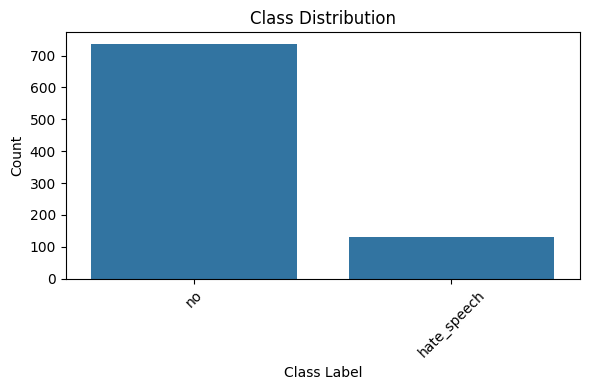


Text Length Statistics:
count    866.000000
mean       9.942263
std        8.717739
min        1.000000
25%        4.000000
50%        7.000000
75%       13.000000
max       68.000000
Name: text_length, dtype: float64


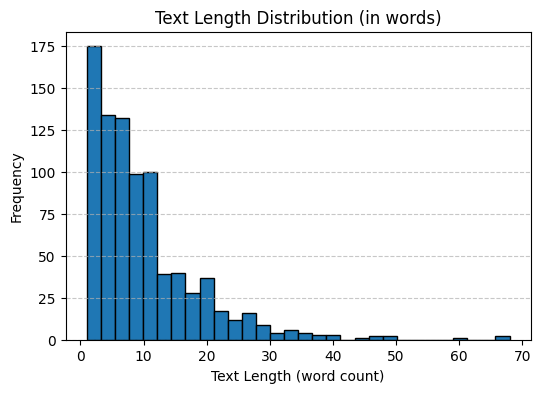


Top 20 Most Frequent Words:
[('να', 322), ('και', 260), ('το', 244), ('δεν', 235), ('είναι', 198), ('που', 152), ('θα', 116), ('η', 109), ('με', 108), ('την', 106), ('τα', 101), ('αυτό', 95), ('ότι', 95), ('για', 90), ('ο', 85), ('εγώ', 75), ('της', 74), ('σε', 73), ('μου', 73), ('από', 69)]


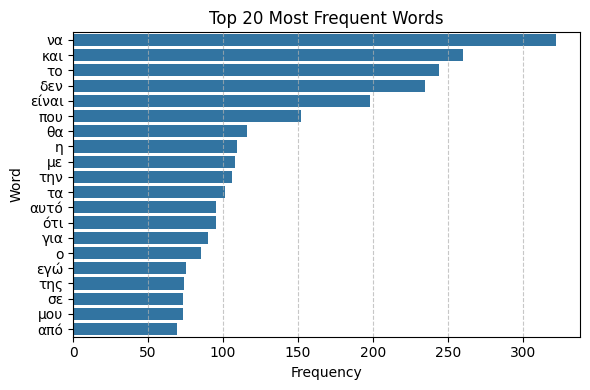

In [18]:
from nltk.tokenize import word_tokenize
# Ensure necessary NLTK resources are downloaded
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)

# --- Class Distribution Analysis ---
print("Class Distribution:")
print(dataset['binary_label'].value_counts())

# Plot class distribution
plt.figure(figsize=(6, 4))
sns.countplot(data=dataset, x='binary_label', order=dataset['binary_label'].value_counts().index)
plt.title("Class Distribution")
plt.xticks(rotation=45)
plt.xlabel("Class Label")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

# --- Text Length Analysis ---
# Compute text length (number of words)
dataset['text_length'] = dataset['cleaned_text'].apply(lambda x: len(x.split()))

# Display text length statistics
print("\nText Length Statistics:")
print(dataset['text_length'].describe())

# Plot distribution of text length
plt.figure(figsize=(6, 4))
plt.hist(dataset['text_length'], bins=30, edgecolor='black')
plt.title("Text Length Distribution (in words)")
plt.xlabel("Text Length (word count)")
plt.ylabel("Frequency")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# --- Word Frequency Analysis ---
# Tokenize cleaned text
dataset['tokens'] = dataset['cleaned_text'].apply(word_tokenize)

# Flatten all tokens into a single list
all_tokens = [word for row in dataset['tokens'] for word in row]
counter = Counter(all_tokens)

# Display the 20 most common words
print("\nTop 20 Most Frequent Words:")
print(counter.most_common(20))

# Plot most frequent words
common_words = counter.most_common(20)
words, freqs = zip(*common_words)

plt.figure(figsize=(6, 4))
sns.barplot(x=list(freqs), y=list(words))
plt.title("Top 20 Most Frequent Words")
plt.xlabel("Frequency")
plt.ylabel("Word")
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


Βήμα 3: Tokenization και Εφαρμογή Stopwords 

In [19]:
from nltk.corpus import stopwords

# Ensure necessary NLTK resources are downloaded
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)

# --- Tokenization ---
# Tokenize cleaned text
dataset['tokens'] = dataset['cleaned_text'].apply(word_tokenize)

# --- Remove punctuation and numbers ---
dataset['tokens'] = dataset['tokens'].apply(
    lambda tokens: [word for word in tokens if word not in string.punctuation and not word.isdigit()]
)

# --- Define and customize Greek stopwords ---
default_stopwords = set(stopwords.words('greek'))

# Additional stopwords based on common Greek words
extra_stopwords = {
    'να', 'και', 'το', 'είναι', 'δεν', 'που', 'την', 'με', 'θα', 'η', 'τα', 'ότι', 'για',
    'μου', 'της', 'αυτό', 'σε', 'από', 'ο', 'Δεν', 'τη', 'τον', 'οι', 'του', 'στην', 'τους',
    'ένα', 'μας', 'στο', 'εγώ', 'έχει', 'σας', 'Και', 'σου', 'τώρα', 'μια', 'Εγώ', 'γιατί',
    'των', 'τι', 'αν', 'αυτή', 'πολύ', 'Να', 'κάτι', 'αυτά', 'Είναι'
}

# Customize stopwords by keeping key terms
custom_stopwords = default_stopwords - {"αυτός", "αυτή", "αυτοί"}
custom_stopwords.update(extra_stopwords)

# Define important words to keep
important_words = {
    "ρατσισμός", "σεξισμός", "ξενοφοβία", "κατά", "δικαιώματα", "προσβολή", "διάκριση",
    "γυναίκα", "άντρας", "μαύρος", "λευκός", "ξένος", "αλλοδαπός"
}

# Ensure important words are not removed
custom_stopwords = {word for word in custom_stopwords if word not in important_words}

print("\nFinal stopwords list:")
print(custom_stopwords)

# --- Remove stopwords from tokens ---
dataset['tokens'] = dataset['tokens'].apply(
    lambda tokens: [word for word in tokens if word not in custom_stopwords]
)

# Display sample tokenized data
print("\nExample tokens after stopword removal:")
print(dataset[['cleaned_text', 'tokens']].head())



Final stopwords list:
{'αυτοι', 'ποτε', 'ἔτι', 'εκεινοι', 'ποῦ', 'μην', 'ποια', 'ὅδε', 'τὴν', 'τησ', 'ο', 'ωσ', 'σὸς', 'ὡς', 'κάτι', 'ἐφ', 'περὶ', "δ'", 'διὰ', 'προ', 'οἱ', 'ὃ', 'στον', 'ισωσ', 'οὓς', 'εἴμι', 'μη', 'τά', 'εκεινεσ', 'ὅσ', 'της', 'οὔτε', 'παρὰ', 'τῶν', 'ἐμὸς', 'ὅστισ', 'ὃν', 'ειμαι', 'κι', 'για', 'οπωσ', 'τι', 'μή', 'ποιοσ', 'ὦ', 'εἰ', 'εκεινη', 'εἰμί', 'δαὶ', 'τινα', 'απο', 'αντι', 'οὐδὲν', 'ἢ', 'δ’', 'οὗτοσ', 'ἐκ', 'οὕτωσ', 'ἑαυτοῦ', 'παρα', 'μετά', 'με', 'οὗ', 'ὅς', 'είναι', 'οὐδεὶς', 'εκεινοσ', "δι'", 'ὅτε', 'δεν', 'ἧς', 'εἰς', 'οὐχ', 'οὕτω', 'ἀλλά', 'τῷ', 'εισαι', 'μέν', 'ὅπερ', 'ἐμόσ', 'εγώ', 'ἐγώ', 'τίς', 'ἂν', 'μὴν', 'τοτε', 'μας', 'να', 'οὖν', 'ὅτι', 'σου', 'δὴ', 'οτι', 'τοι', 'τις', 'αὖ', 'έχει', 'σύ', 'διά', 'μετα', 'οὐδ', 'μια', 'τοῦ', 'τὸ', 'γοῦν', 'που', 'τους', 'σὺν', 'εἴ', 'ἐγὼ', 'οὐδὲ', 'ἥ', 'ἀπ', 'αλλα', 'τῆς', 'των', 'γάρ', 'ταῖς', 'ἐπί', 'ποιεσ', 'τη', 'ὅστις', 'αυτά', 'αυτο', 'τόν', 'ειναι', 'ποιο', 'δαίσ', 'Να', 'στην', 'τότε', 'οὐκ', 'παρ', 'δὲ', 

Βήμα 4: Undersampling της Κλάσης "no" 

In [20]:
# --- Display class distribution before undersampling ---
print("\nClass Distribution Before Undersampling:")
print(dataset['binary_label'].value_counts())

# --- Separate "no" class from other classes ---
dataset_no = dataset[dataset['binary_label'] == 'no']
dataset_other = dataset[dataset['binary_label'] != 'no']

# --- Randomly select 130 samples from the "no" class ---
dataset_no_sampled = dataset_no.sample(n=130, random_state=42)

# --- Combine sampled "no" class with all other classes ---
dataset_balanced = pd.concat([dataset_no_sampled, dataset_other]).reset_index(drop=True)

# --- Display class distribution after undersampling ---
print("\nClass Distribution After Undersampling:")
print(dataset_balanced['binary_label'].value_counts())



Class Distribution Before Undersampling:
no             736
hate_speech    130
Name: binary_label, dtype: int64

Class Distribution After Undersampling:
no             130
hate_speech    130
Name: binary_label, dtype: int64


Βήμα 5: Προετοιμασία Κειμένου για TF-IDF 

In [21]:
# Convert tokenized words back into a single string for TF-IDF vectorization
dataset_balanced['processed_text'] = dataset_balanced['tokens'].apply(lambda tokens: ' '.join(tokens))


Βήμα 6: Μετατροπή σε Χαρακτηριστικά με TF-IDF 

In [22]:
# Initialize TF-IDF vectorizer with a maximum of 5000 features
tfidf = TfidfVectorizer(max_features=5000)

# Transform processed text into a TF-IDF feature matrix
X = tfidf.fit_transform(dataset_balanced['processed_text'])

# Extract binary labels for classification
y = dataset_balanced['binary_label']

# Print the shape of the resulting TF-IDF matrix
print("\nShape of TF-IDF Feature Matrix:", X.shape)



Shape of TF-IDF Feature Matrix: (260, 1091)


Βήμα 7: Μείωση Διαστάσεων με PCA και Οπτικοποίηση 

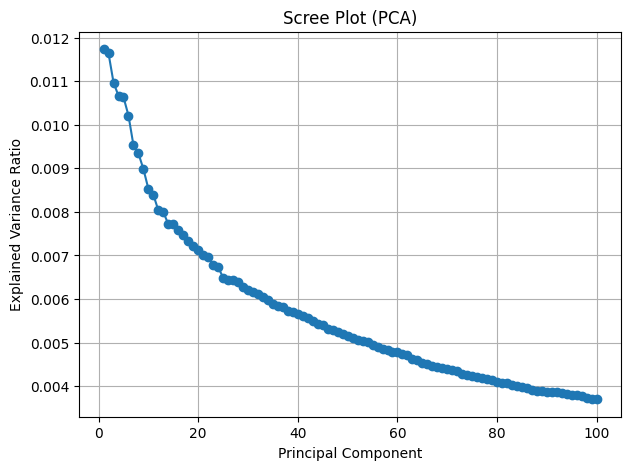

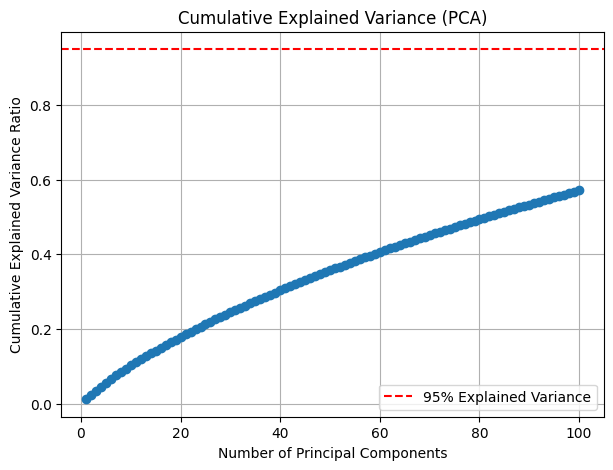

In [23]:
# Apply PCA to reduce dimensionality
pca = PCA(n_components=100, random_state=42)
X_reduced = pca.fit_transform(X.toarray())  # Convert sparse matrix to dense format for PCA

# Explained variance ratio for each principal component
exp_var_ratio = pca.explained_variance_ratio_

# --- Scree Plot: Explained variance per principal component ---
plt.figure(figsize=(7, 5))
plt.plot(range(1, len(exp_var_ratio) + 1), exp_var_ratio, marker='o', linestyle='-')
plt.title('Scree Plot (PCA)')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.grid(True)
plt.show()

# --- Cumulative Explained Variance Plot ---
cum_exp_var = np.cumsum(exp_var_ratio)
plt.figure(figsize=(7, 5))
plt.plot(range(1, len(cum_exp_var) + 1), cum_exp_var, marker='o', linestyle='-')
plt.axhline(y=0.95, color='r', linestyle='--', label="95% Explained Variance")
plt.title('Cumulative Explained Variance (PCA)')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.legend()
plt.grid(True)
plt.show()


Βήμα 8: Ταξινόμηση με Leave-One-Out Cross-Validation 

BINARY PCA LOGISTIC REGRESSION


Performance Metrics:
Precision (macro): 0.6425
Recall (macro):    0.5423
F1-score (macro):  0.4447

Classification Report:
              precision    recall  f1-score   support

 hate_speech       0.52      0.96      0.68       130
          no       0.76      0.12      0.21       130

    accuracy                           0.54       260
   macro avg       0.64      0.54      0.44       260
weighted avg       0.64      0.54      0.44       260


Confusion Matrix:
[[125   5]
 [114  16]]


<Figure size 600x500 with 0 Axes>

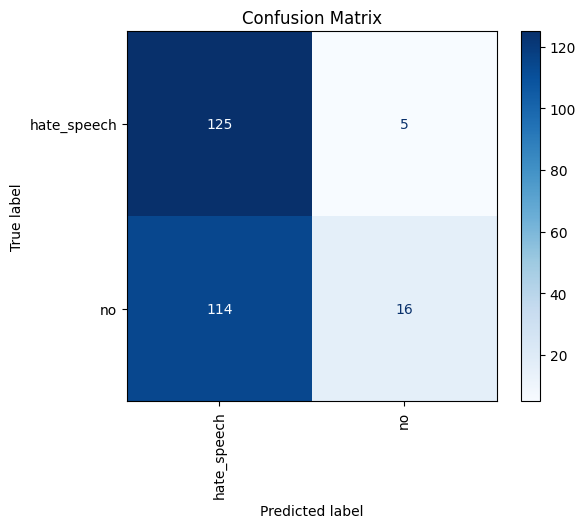

In [24]:
from sklearn.decomposition import PCA
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import LeaveOneOut, cross_val_predict
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    confusion_matrix, precision_score, recall_score, 
    f1_score, classification_report, ConfusionMatrixDisplay
)
import numpy as np
import matplotlib.pyplot as plt

# Initialize Leave-One-Out Cross-Validation
loo = LeaveOneOut()

# Create a pipeline integrating PCA and Naïve Bayes
pipeline = Pipeline([
    ('pca', PCA(n_components=100, random_state=42)),  # Reduce dimensionality to 100 components
    ('clf', GaussianNB())  # Gaussian Naïve Bayes Classifier
])

# Apply LOO-CV and predict labels
y_pred = cross_val_predict(pipeline, X.toarray(), y, cv=loo)  # Convert sparse TF-IDF matrix to dense format for PCA

# Compute confusion matrix
cm = confusion_matrix(y, y_pred)

# Compute performance metrics
precision = precision_score(y, y_pred, average='macro')
recall = recall_score(y, y_pred, average='macro')
f1 = f1_score(y, y_pred, average='macro')

# Display performance results
print("\nPerformance Metrics:")
print(f"Precision (macro): {precision:.4f}")
print(f"Recall (macro):    {recall:.4f}")
print(f"F1-score (macro):  {f1:.4f}")

# Print classification report
print("\nClassification Report:")
print(classification_report(y, y_pred))

# --- Confusion Matrix Visualization ---
print("\nConfusion Matrix:")
print(cm)

# Visualize confusion matrix
plt.figure(figsize=(6, 5))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y))
disp.plot(cmap="Blues", xticks_rotation='vertical')

# Improve visualization aesthetics
plt.title("Confusion Matrix")
plt.grid(False)  # Remove grid for clarity
plt.show()


BINARY PCA NAIVE BASE

In [ ]:
from sklearn.decomposition import PCA
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import LeaveOneOut, cross_val_predict
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    confusion_matrix, precision_score, recall_score, 
    f1_score, classification_report, ConfusionMatrixDisplay
)
import numpy as np
import matplotlib.pyplot as plt

# Initialize Leave-One-Out Cross-Validation
loo = LeaveOneOut()

# Create a pipeline integrating PCA and Naïve Bayes
pipeline = Pipeline([
    ('pca', PCA(n_components=100, random_state=42)),  # Reduce dimensionality to 100 components
    ('clf', GaussianNB())  # Gaussian Naïve Bayes Classifier
])

# Apply LOO-CV and predict labels
y_pred = cross_val_predict(pipeline, X.toarray(), y, cv=loo)  # Convert sparse TF-IDF matrix to dense format for PCA

# Compute confusion matrix
cm = confusion_matrix(y, y_pred)

# Compute performance metrics
precision = precision_score(y, y_pred, average='macro')
recall = recall_score(y, y_pred, average='macro')
f1 = f1_score(y, y_pred, average='macro')

# Display performance results
print("\nPerformance Metrics:")
print(f"Precision (macro): {precision:.4f}")
print(f"Recall (macro):    {recall:.4f}")
print(f"F1-score (macro):  {f1:.4f}")

# Print classification report
print("\nClassification Report:")
print(classification_report(y, y_pred))

# --- Confusion Matrix Visualization ---
print("\nConfusion Matrix:")
print(cm)

# Visualize confusion matrix
plt.figure(figsize=(6, 5))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y))
disp.plot(cmap="Blues", xticks_rotation='vertical')

# Improve visualization aesthetics
plt.title("Confusion Matrix")
plt.grid(False)  # Remove grid for clarity
plt.show()


BINARY PCA SVM 

In [ ]:
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.model_selection import LeaveOneOut, cross_val_predict
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    confusion_matrix, precision_score, recall_score, 
    f1_score, classification_report, ConfusionMatrixDisplay
)
import numpy as np
import matplotlib.pyplot as plt

# Initialize Leave-One-Out Cross-Validation
loo = LeaveOneOut()

# Create a pipeline integrating PCA and SVM
pipeline = Pipeline([
    ('pca', PCA(n_components=200, random_state=42)),  # Reduce dimensionality to 200 components
    ('clf', SVC(kernel='linear', C=1.0, random_state=42))  # Linear SVM Classifier
])

# Apply LOO-CV and predict labels
y_pred = cross_val_predict(pipeline, X.toarray(), y, cv=loo)  # Convert sparse TF-IDF matrix to dense format for PCA

# Compute confusion matrix
cm = confusion_matrix(y, y_pred)

# Compute performance metrics
precision = precision_score(y, y_pred, average='macro')
recall = recall_score(y, y_pred, average='macro')
f1 = f1_score(y, y_pred, average='macro')

# Display performance results
print("\nPerformance Metrics:")
print(f"Precision (macro): {precision:.4f}")
print(f"Recall (macro):    {recall:.4f}")
print(f"F1-score (macro):  {f1:.4f}")

# Print classification report
print("\nClassification Report:")
print(classification_report(y, y_pred))

# --- Confusion Matrix Visualization ---
print("\nConfusion Matrix:")
print(cm)

# Visualize confusion matrix
plt.figure(figsize=(6, 5))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y))
disp.plot(cmap="Blues", xticks_rotation='vertical')

# Improve visualization aesthetics
plt.title("Confusion Matrix")
plt.grid(False)  # Remove grid for clarity
plt.show()
